<a href="https://colab.research.google.com/github/arbhavana/Electrical-Outage-Prediction/blob/main/electrical_outage_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load the data
data_path = 'WeatherOutagesAllJerry.csv'
data = pd.read_csv(data_path)

# Display the first few rows of the data
print(data.head())
print(data.columns)

      Date  Total_outages  Equipment  Trees  Animals  Lightning  \
0  9/11/00            0.0        0.0    0.0      0.0        0.0   
1  9/12/00            2.0        1.0    0.0      1.0        0.0   
2  9/13/00            1.0        1.0    0.0      0.0        0.0   
3  9/14/00            0.0        0.0    0.0      0.0        0.0   
4  9/15/00            1.0        1.0    0.0      0.0        0.0   

   Day_length_hr  Max_temp_F  Avg_Temp_F  Min_temp_F  ...  Avg_windspeed_mph  \
0      12.783333        66.0        58.0        50.0  ...                2.0   
1      12.716667        75.0        62.0        52.0  ...                4.0   
2      12.666667        77.0        64.0        54.0  ...                7.0   
3      12.616667        84.0        71.0        60.0  ...               12.0   
4      12.550000        73.0        66.0        59.0  ...                5.0   

   Max_windgust_mph  Precipitation_in  Events  Event_fog  Event_rain  \
0               9.0              0.01     Fo

Data Preprocessing

In [4]:

# Drop the unnecessary columns
data_cleaned = data.drop(columns=['Date', 'Events','Event_rain', 'Event_snow',
       'Event_thunderstorm', 'Event_Hail', 'Event_Tornado', 'Event_fog'])

# Handle missing values by filling with the median value of each column
data_cleaned = data_cleaned.fillna(data_cleaned.median())

Feature Selection

In [5]:
# Split the data into features and target variable
features = data_cleaned.drop(columns=['Total_outages'])
target_outages = data_cleaned['Total_outages']
print(features.columns)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target_outages, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Index(['Equipment', 'Trees', 'Animals', 'Lightning', 'Day_length_hr',
       'Max_temp_F', 'Avg_Temp_F', 'Min_temp_F', 'Max_humidity_percent',
       'Avg_humidity_percent', 'Min_humidity_percent', 'Max_visibility_mi',
       'Avg_visibility_mi', 'Min_visibility_mi', 'Max_windspeed_mph',
       'Avg_windspeed_mph', 'Max_windgust_mph', 'Precipitation_in'],
      dtype='object')



Predicting the tota number of outages and comparing the results of various regression algoritms

In [6]:
# Regression Algorithms
regressors = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'LinearRegression': LinearRegression(),
    'SVR': SVR()                                   #Support vector regressor
}

regression_results = {}
for name, regressor in regressors.items():
    regressor.fit(X_train_scaled, y_train)
    y_pred = regressor.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    regression_results[name] = (y_pred, mse)
    print(f'{name} Mean Squared Error: {mse}')

# Neural Network for Regression
model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train_scaled, y_train, epochs=100, batch_size=10, verbose=0)
y_pred_nn = model.predict(X_test_scaled)
mse_nn = mean_squared_error(y_test, y_pred_nn)
regression_results['NeuralNetwork'] = (y_pred_nn.flatten(), mse_nn)
print(f'Neural Network Mean Squared Error: {mse_nn}')

RandomForest Mean Squared Error: 0.4223911583659764
LinearRegression Mean Squared Error: 0.044170685971934354
SVR Mean Squared Error: 0.9666108976244199
56/56 [==============================] - 0s 1ms/step
Neural Network Mean Squared Error: 0.0018748459292640507


In [7]:
# Choose the best regression model (with the lowest MSE) for further use
best_regressor_name = min(regression_results, key=lambda x: regression_results[x][1])
best_y_pred_outages = regression_results[best_regressor_name][0]
print(f'Best regression model: {best_regressor_name}')


Best regression model: NeuralNetwork


In [8]:
# Add the predicted outages to the features for classification
X_test_with_predicted_outages = X_test.copy()
X_test_with_predicted_outages['Predicted_outages'] = best_y_pred_outages
print(features.columns)


Index(['Equipment', 'Trees', 'Animals', 'Lightning', 'Day_length_hr',
       'Max_temp_F', 'Avg_Temp_F', 'Min_temp_F', 'Max_humidity_percent',
       'Avg_humidity_percent', 'Min_humidity_percent', 'Max_visibility_mi',
       'Avg_visibility_mi', 'Min_visibility_mi', 'Max_windspeed_mph',
       'Avg_windspeed_mph', 'Max_windgust_mph', 'Precipitation_in'],
      dtype='object')


In [9]:
from sklearn.impute import SimpleImputer

# Causes and their corresponding columns
causes = ['Equipment', 'Trees', 'Animals', 'Lightning']
data_cleaned['cause'] = data_cleaned[causes].idxmax(axis=1)
# Encode the cause column
data_cleaned['cause'] = data_cleaned['cause'].astype('category').cat.codes
features = data_cleaned.drop(columns=['cause'] + causes)



# Split the data into features and target variable for classification
target_cause = data_cleaned['cause']
X_train_cause, X_test_cause, y_train_cause, y_test_cause = train_test_split(features, target_cause, test_size=0.3, random_state=42)


# Add the actual outages to the training features for classification
X_train_cause['Total_outages'] = y_train

X_test_cause['Total_outages'] = best_y_pred_outages  # Use predicted outages in the test set

# Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_cause_imputed = imputer.fit_transform(X_train_cause)
X_test_cause_imputed = imputer.transform(X_test_cause)

# Standardize the features for classification
scaler = StandardScaler()
X_train_cause_scaled = scaler.fit_transform(X_train_cause_imputed)
X_test_cause_scaled = scaler.transform(X_test_cause_imputed)

RandomForest Classification Accuracy: 0.846670397313934
RandomForest Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.15      0.24       142
           1       0.86      0.98      0.91      1483
           2       0.00      0.00      0.00         6
           3       0.77      0.22      0.34       156

    accuracy                           0.85      1787
   macro avg       0.54      0.34      0.37      1787
weighted avg       0.82      0.85      0.81      1787

LogisticRegression Classification Accuracy: 0.8483491885842194
LogisticRegression Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.11      0.19       142
           1       0.85      0.99      0.92      1483
           2       0.00      0.00      0.00         6
           3       0.74      0.22      0.34       156

    accuracy                           0.85      1787
   macro avg       0.56      0.33      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

SVC Classification Accuracy: 0.8410744264129827
SVC Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.01      0.01       142
           1       0.84      1.00      0.91      1483
           2       0.00      0.00      0.00         6
           3       1.00      0.13      0.23       156

    accuracy                           0.84      1787
   macro avg       0.58      0.28      0.29      1787
weighted avg       0.82      0.84      0.78      1787



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


56/56 [==============================] - 0s 1ms/step
Neural Network Classification Accuracy: 0.7901510912143257
Neural Network Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.38      0.33       142
           1       0.89      0.88      0.88      1483
           2       0.17      0.17      0.17         6
           3       0.39      0.32      0.35       156

    accuracy                           0.79      1787
   macro avg       0.44      0.44      0.43      1787
weighted avg       0.80      0.79      0.79      1787

Best classification model: LogisticRegression
Total predicted outages: 2018
Total predicted causes: 1787


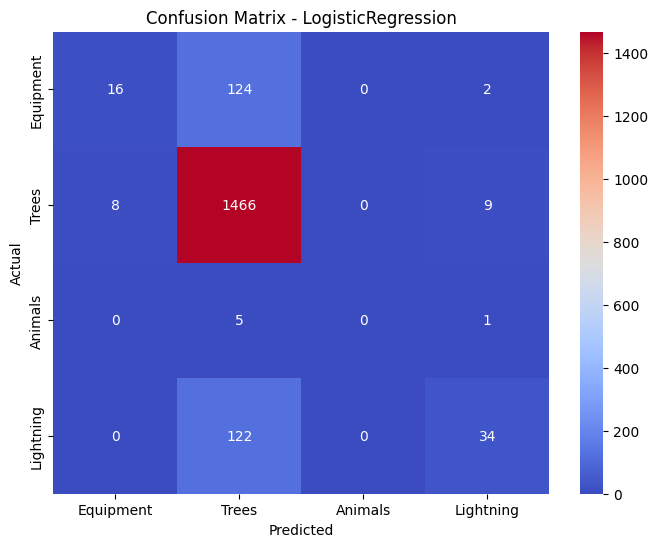

In [10]:
# Classification Algorithms
classifiers = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'SVC': SVC()
}

classification_results = {}
for name, classifier in classifiers.items():
    classifier.fit(X_train_cause_scaled, y_train_cause)
    y_pred_cause = classifier.predict(X_test_cause_scaled)
    accuracy = accuracy_score(y_test_cause, y_pred_cause)
    classification_results[name] = (y_pred_cause, accuracy)
    print(f'{name} Classification Accuracy: {accuracy}')
    print(f'{name} Classification Report:\n', classification_report(y_test_cause, y_pred_cause))

# Neural Network for Classification
model = Sequential()
model.add(Dense(64, input_dim=X_train_cause_scaled.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(causes), activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train_cause_scaled, y_train_cause, epochs=100, batch_size=10, verbose=0)
y_pred_cause_nn_prob = model.predict(X_test_cause_scaled)
y_pred_cause_nn_classes = np.argmax(y_pred_cause_nn_prob, axis=1)
accuracy_nn = accuracy_score(y_test_cause, y_pred_cause_nn_classes)
classification_results['NeuralNetwork'] = (y_pred_cause_nn_classes, accuracy_nn)
print(f'Neural Network Classification Accuracy: {accuracy_nn}')
print('Neural Network Classification Report:\n', classification_report(y_test_cause, y_pred_cause_nn_classes))

# Choose the best classifier (with the highest accuracy) for further use
best_classifier_name = max(classification_results, key=lambda x: classification_results[x][1])
best_y_pred_cause = classification_results[best_classifier_name][0]
print(f'Best classification model: {best_classifier_name}')

# Ensure total predicted outages matches total predicted causes
total_predicted_outages = np.round(best_y_pred_outages).astype(int)
total_predicted_outages = np.clip(total_predicted_outages, 0, None)  # Ensure no negative values

total_predicted_cause_counts = np.bincount(best_y_pred_cause, minlength=len(causes))

print(f'Total predicted outages: {total_predicted_outages.sum()}')
print(f'Total predicted causes: {total_predicted_cause_counts.sum()}')

# Confusion matrix for the best classifier
conf_matrix = confusion_matrix(y_test_cause, best_y_pred_cause)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=causes, yticklabels=causes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix - {best_classifier_name}')
plt.show()


!pip install streamlit
